## Giai đoạn 1: Mục tiêu & Chuẩn bị dữ liệu

Mục tiêu của phần EDA này là hiểu rõ cấu trúc dữ liệu, phát hiện lỗi/missing, nhận diện seasonality, và tạo những đặc trưng nền tảng cho mô hình dự báo doanh số bán lẻ kiểu Rossmann. Các giả định cần kiểm tra:
- Open = 0 thì Sales phải bằng 0.
- Ngày nào Open = 1 mà Sales = 0 cần được đánh dấu vì có thể là lỗi nhập hoặc ngày nghỉ.
- Promo được kỳ vọng làm tăng Sales, nhưng cần kiểm chứng và chú ý bias theo ngày trong tuần.
- Các trường StateHoliday nhất quán về định dạng.

Bên dưới là phần thiết lập thư viện và dữ liệu để phục vụ toàn bộ 5 giai đoạn.

In [36]:
# Core stack for the exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use("seaborn-v0_8")
sns.set_theme(style="whitegrid", context="talk")
pd.set_option("display.float_format", "{:.2f}".format)

### Thiết lập đường dẫn & đọc nhanh dữ liệu

- Đọc `train.csv`, `test.csv`, `store.csv` với `parse_dates=['Date']` để giữ thông tin thời gian.
- Quan sát kích thước, vài dòng đầu để đảm bảo schema kỳ vọng.
- Kiểm tra sơ bộ duplicate trước khi đi sâu hơn.

In [37]:
# Load raw CSVs (dates parsed for time-series ops)
DATA_DIR = Path("data")
TRAIN_PATH = DATA_DIR / "train.csv"
TEST_PATH = DATA_DIR / "test.csv"
STORE_PATH = DATA_DIR / "store.csv"

train_df = pd.read_csv(TRAIN_PATH, parse_dates=["Date"])
test_df = pd.read_csv(TEST_PATH, parse_dates=["Date"])
store_df = pd.read_csv(STORE_PATH)

print(f"Train shape: {train_df.shape}")
print(f"Test shape : {test_df.shape}")
print(f"Store shape: {store_df.shape}")

┌───────────────────────────────── ⚠️ Warning ─────────────────────────────────┐
│ DtypeWarning in                                                             │
│ C:\Users\Admin\AppData\Local\Temp\ipykernel_12396\2159666301.py:7           │
│ Columns (7) have mixed types. Specify dtype option on import or set         │
│ low_memory=False.                                                           │
└─────────────────────────────────────────────────────────────────────────────┘
Train shape: (1001599, 10)
Test shape : (1115, 9)
Store shape: (1115, 10)
Train shape: (1001599, 10)
Test shape : (1115, 9)
Store shape: (1115, 10)


In [38]:
# Quick structural glimpse
print("Train preview:")
display(train_df.head())
print("\nTest preview:")
display(test_df.head())
print("\nStore preview:")
display(store_df.head())

Train preview:


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Id
0,1,5,2015-07-17,4852,519,1,1,0,0,303445
1,2,5,2015-07-17,4518,495,1,1,0,1,959585
2,3,5,2015-07-17,6679,673,1,1,0,1,739744
3,4,5,2015-07-17,10514,1343,1,1,0,1,864001
4,5,5,2015-07-17,4355,513,1,1,0,1,981931



Test preview:


,Id,Store,DayOfWeek,Date,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,879066,1,5,2015-07-31,555,1,1,0,1
1,37135,2,5,2015-07-31,625,1,1,0,1
2,285919,3,5,2015-07-31,821,1,1,0,1
3,744348,4,5,2015-07-31,1498,1,1,0,1
4,556250,5,5,2015-07-31,559,1,1,0,1



Store preview:


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,2,a,a,570.00,11.00,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.00,12.00,2006.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
3,4,c,c,620.00,9.00,2009.00,0,NaN,NaN,NaN
4,5,a,a,29910.00,4.00,2015.00,0,NaN,NaN,NaN


In [39]:
# Structural metadata (non-null counts & dtypes)
for name, df in {"train": train_df, "test": test_df, "store": store_df}.items():
    print(f"\n{name.title()} info:")
    df.info(memory_usage="deep")


Train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001599 entries, 0 to 1001598
Data columns (total 10 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1001599 non-null  int64         
 1   DayOfWeek      1001599 non-null  int64         
 2   Date           1001599 non-null  datetime64[ns]
 3   Sales          1001599 non-null  int64         
 4   Customers      1001599 non-null  int64         
 5   Open           1001599 non-null  int64         
 6   Promo          1001599 non-null  int64         
 7   StateHoliday   1001599 non-null  object        
 8   SchoolHoliday  1001599 non-null  int64         
 9   Id             1001599 non-null  int64         
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 119.3 MB

Test info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         

In [40]:
# Descriptive stats for numeric columns
summary_tables = {
    "train_numeric": train_df.describe().transpose(),
    "test_numeric": test_df.describe().transpose(),
    "store_numeric": store_df.describe().transpose()
}
for name, table in summary_tables.items():
    print(f"\n{name} stats:")
    display(table)


train_numeric stats:


,count,mean,min,25%,50%,75%,max,std
Store,1001599.00,558.44,1.00,280.00,558.00,838.00,1115.00,321.91
DayOfWeek,1001599.00,4.00,1.00,2.00,4.00,6.00,7.00,2.00
Date,1001599,2014-04-03 17:55:22.042054400,2013-01-01 00:00:00,2013-08-13 00:00:00,2014-03-26 00:00:00,2014-11-30 00:00:00,2015-07-17 00:00:00,NaN
Sales,1001599.00,5770.57,0.00,3722.00,5741.00,7854.00,41551.00,3852.57
Customers,1001599.00,633.30,0.00,404.00,610.00,838.00,7388.00,464.94
Open,1001599.00,0.83,0.00,1.00,1.00,1.00,1.00,0.38
Promo,1001599.00,0.38,0.00,0.00,0.00,1.00,1.00,0.49
SchoolHoliday,1001599.00,0.17,0.00,0.00,0.00,0.00,1.00,0.38
Id,1001599.00,508518.86,0.00,254441.00,508810.00,762642.50,1017207.00,293464.69



test_numeric stats:


,count,mean,min,25%,50%,75%,max,std
Id,1115.00,496286.22,2325.00,244464.00,490146.00,752570.00,1016764.00,292965.13
Store,1115.00,558.00,1.00,279.50,558.00,836.50,1115.00,322.02
DayOfWeek,1115.00,5.00,5.00,5.00,5.00,5.00,5.00,0.00
Date,1115,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,NaN
Customers,1115.00,868.72,0.00,631.00,787.00,989.50,3745.00,388.02
Open,1115.00,1.00,0.00,1.00,1.00,1.00,1.00,0.04
Promo,1115.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00
StateHoliday,1115.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SchoolHoliday,1115.00,0.84,0.00,1.00,1.00,1.00,1.00,0.37



store_numeric stats:


,count,mean,std,min,25%,50%,75%,max
Store,1115.00,558.00,322.02,1.00,279.50,558.00,836.50,1115.00
CompetitionDistance,1112.00,5404.90,7663.17,20.00,717.50,2325.00,6882.50,75860.00
CompetitionOpenSinceMonth,761.00,7.22,3.21,1.00,4.00,8.00,10.00,12.00
CompetitionOpenSinceYear,761.00,2008.67,6.20,1900.00,2006.00,2010.00,2013.00,2015.00
Promo2,1115.00,0.51,0.50,0.00,0.00,1.00,1.00,1.00
Promo2SinceWeek,571.00,23.60,14.14,1.00,13.00,22.00,37.00,50.00
Promo2SinceYear,571.00,2011.76,1.67,2009.00,2011.00,2012.00,2013.00,2015.00


In [41]:
# Duplicate check to ensure unique Store-Date rows
train_dupes = train_df.duplicated(subset=["Store", "Date"]).sum()
test_dupes = test_df.duplicated(subset=["Store", "Date"]).sum()
print(f"Train duplicate Store-Date rows: {train_dupes}")
print(f"Test duplicate Store-Date rows : {test_dupes}")

Train duplicate Store-Date rows: 0
Test duplicate Store-Date rows : 0


## Giai đoạn 2: Làm sạch & xử lý missing

Trọng tâm: định lượng missing %, bổ sung flag thay vì đoán mò, và chuẩn hoá các cột quan trọng (Competition, Promo, StateHoliday). Sau đó chạy sanity check cho các giả định kinh doanh (Open/Sales).

In [42]:
# Missing value ratio per column (sorted)
def missing_report(df: pd.DataFrame, name: str, top_n: int = 15) -> pd.DataFrame:
    ratio = df.isna().mean().sort_values(ascending=False) * 100
    report = ratio.head(top_n).to_frame(name="missing_pct")
    report["missing_pct"] = report["missing_pct"].round(2)
    report["rows"] = len(df)
    print(f"\n{name} missing summary (top {top_n}):")
    display(report)
    return report

missing_report(train_df, "Train")
missing_report(test_df, "Test")
missing_report(store_df, "Store")


Train missing summary (top 15):


,missing_pct,rows
Store,0.00,1001599
DayOfWeek,0.00,1001599
Date,0.00,1001599
Sales,0.00,1001599
Customers,0.00,1001599
Open,0.00,1001599
Promo,0.00,1001599
StateHoliday,0.00,1001599
SchoolHoliday,0.00,1001599
Id,0.00,1001599



Test missing summary (top 15):


,missing_pct,rows
Id,0.00,1115
Store,0.00,1115
DayOfWeek,0.00,1115
Date,0.00,1115
Customers,0.00,1115
Open,0.00,1115
Promo,0.00,1115
StateHoliday,0.00,1115
SchoolHoliday,0.00,1115



Store missing summary (top 15):


,missing_pct,rows
PromoInterval,48.79,1115
Promo2SinceYear,48.79,1115
Promo2SinceWeek,48.79,1115
CompetitionOpenSinceYear,31.75,1115
CompetitionOpenSinceMonth,31.75,1115
CompetitionDistance,0.27,1115
StoreType,0.00,1115
Store,0.00,1115
Assortment,0.00,1115
Promo2,0.00,1115


,missing_pct,rows
PromoInterval,48.79,1115
Promo2SinceYear,48.79,1115
Promo2SinceWeek,48.79,1115
CompetitionOpenSinceYear,31.75,1115
CompetitionOpenSinceMonth,31.75,1115
CompetitionDistance,0.27,1115
StoreType,0.00,1115
Store,0.00,1115
Assortment,0.00,1115
Promo2,0.00,1115


In [43]:
# Competition & promo cleaning with explicit flags
store_df["CompetitionMissingFlag"] = store_df["CompetitionDistance"].isna().astype(int)
comp_median = store_df["CompetitionDistance"].median()
store_df["CompetitionDistance"] = store_df["CompetitionDistance"].fillna(comp_median).fillna(200000)

competition_cols = ["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"]
promo_cols = ["Promo2SinceWeek", "Promo2SinceYear", "PromoInterval"]
for col in competition_cols + promo_cols:
    flag_name = f"{col}MissingFlag"
    store_df[flag_name] = store_df[col].isna().astype(int)

store_df["PromoInterval"] = store_df["PromoInterval"].fillna("None")

# Normalize StateHoliday representation across train/test
for frame in [train_df, test_df]:
    frame["StateHoliday"] = frame["StateHoliday"].astype(str).str.lower().replace({"0": "0", "nan": "0"})
    frame["Open"] = frame["Open"].fillna(1)

print("Finished imputations + flag creation for store metadata.")

Finished imputations + flag creation for store metadata.


In [44]:
# Sanity checks for business rules
open_closed_sales = train_df[(train_df["Open"] == 0) & (train_df["Sales"] > 0)]
open_sales_zero = train_df[(train_df["Open"] == 1) & (train_df["Sales"] == 0)]
print(f"Open=0 but Sales>0 rows : {len(open_closed_sales)}")
print(f"Open=1 but Sales=0 rows : {len(open_sales_zero)}")

stateholiday_levels = train_df["StateHoliday"].unique()
print(f"StateHoliday unique labels: {stateholiday_levels}")

# Merge store info for downstream analysis
train_full = train_df.merge(store_df, on="Store", how="left")
test_full = test_df.merge(store_df, on="Store", how="left")
print(f"Merged train shape: {train_full.shape}")

Open=0 but Sales>0 rows : 0
Open=1 but Sales=0 rows : 54
StateHoliday unique labels: ['0' 'a' 'b' 'c']
Merged train shape: (1001599, 25)
Merged train shape: (1001599, 25)


## Giai đoạn 3: Phân tích sâu & trực quan hoá

Phân tích mục tiêu (Sales, Customers), cấu trúc thời gian (trend-seasonality-residual), và tác động của Promo/Holiday/Competitor. Tập trung vào các biểu đồ giúp chọn đặc trưng & kiểm chứng giả định.

In [45]:
# Helper subset: only open days for fair comparisons
open_days = train_full[train_full["Open"] == 1].copy()
train_full["LogSales"] = np.log1p(train_full["Sales"].clip(lower=0))

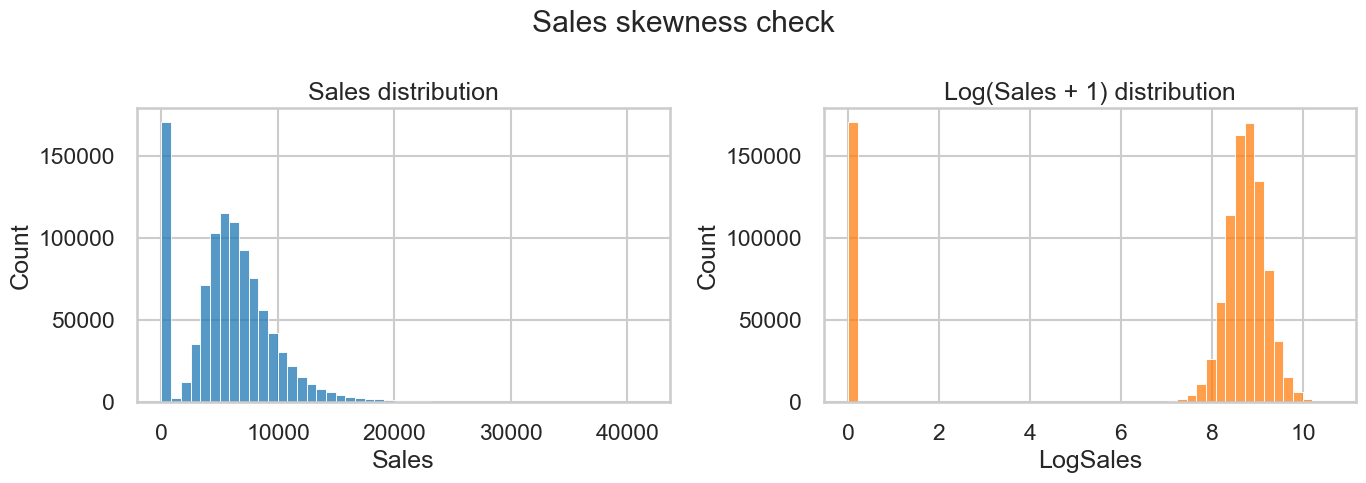

In [46]:
# Distribution of Sales vs log-transformed Sales
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(train_full["Sales"], bins=50, ax=axes[0], color="#1f77b4")
axes[0].set_title("Sales distribution")
axes[0].set_xlabel("Sales")
sns.histplot(train_full["LogSales"], bins=50, ax=axes[1], color="#ff7f0e")
axes[1].set_title("Log(Sales + 1) distribution")
axes[1].set_xlabel("LogSales")
plt.suptitle("Sales skewness check")
plt.tight_layout()
plt.show()

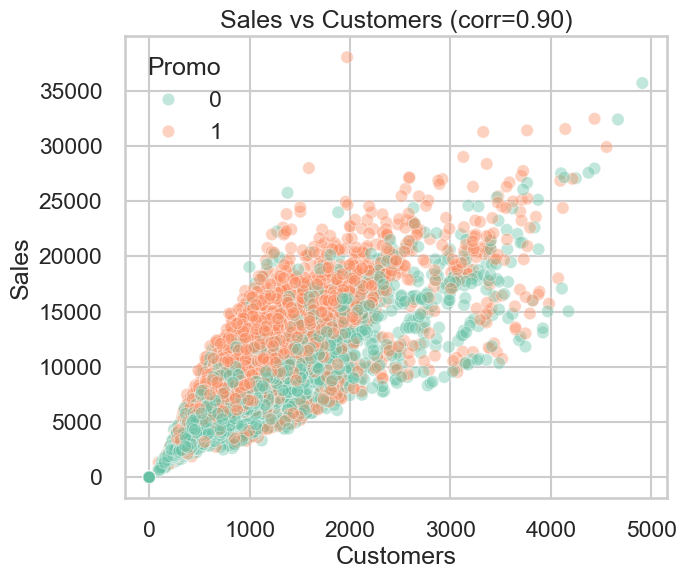

In [47]:
# Relationship between Sales and Customers
sample_size = min(50000, len(train_full))
scatter_sample = train_full.sample(n=sample_size, random_state=42) if sample_size < len(train_full) else train_full
corr_val = train_full[["Sales", "Customers"]].corr().iloc[0, 1]
plt.figure(figsize=(7, 6))
sns.scatterplot(data=scatter_sample, x="Customers", y="Sales", hue="Promo", alpha=0.4, palette="Set2")
plt.title(f"Sales vs Customers (corr={corr_val:.2f})")
plt.show()

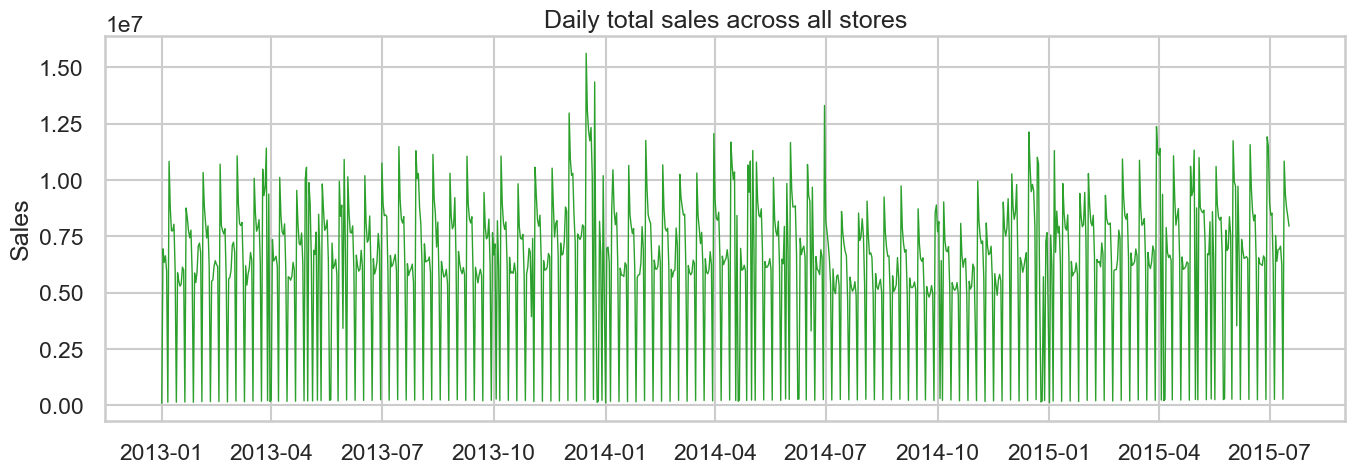

In [48]:
# Daily aggregated sales to inspect trend/seasonality envelope
daily_sales = (train_full
               .set_index("Date")
               .sort_index()
               .resample("D")
               .sum(numeric_only=True)["Sales"]
               .fillna(0))
plt.figure(figsize=(16, 5))
plt.plot(daily_sales.index, daily_sales.values, color="#2ca02c", linewidth=1)
plt.title("Daily total sales across all stores")
plt.ylabel("Sales")
plt.show()

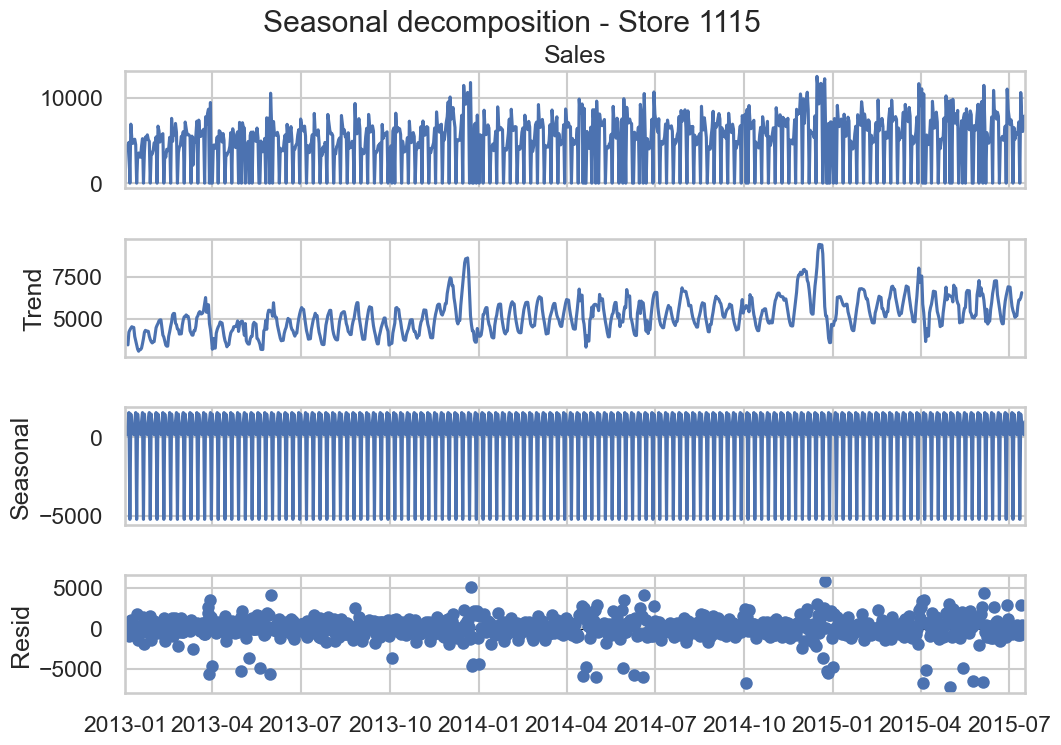

In [49]:
# Seasonal decomposition for a representative store
store_example = train_full["Store"].value_counts().idxmax()
store_ts = (train_full[train_full["Store"] == store_example]
            .set_index("Date")
            .sort_index()["Sales"]
            .asfreq("D"))
store_ts = store_ts.interpolate(limit_direction="both")
decomp = seasonal_decompose(store_ts, model="additive", period=7)
fig = decomp.plot()
fig.set_size_inches(12, 8)
fig.suptitle(f"Seasonal decomposition - Store {store_example}")
plt.show()

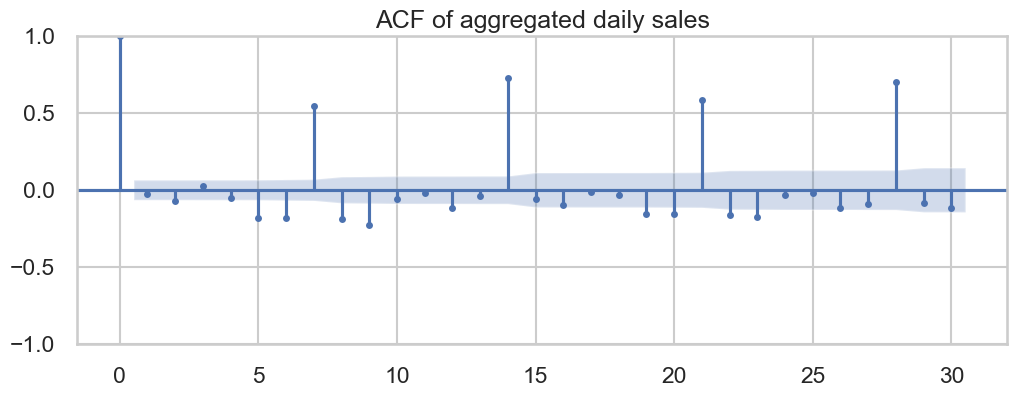

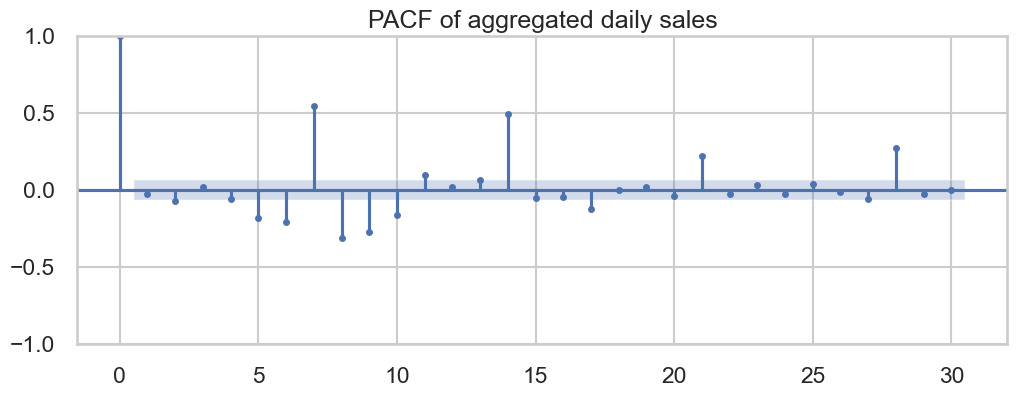

In [50]:
# ACF/PACF to hint potential lags
plt.figure(figsize=(12, 4))
plot_acf(daily_sales, lags=30, ax=plt.gca())
plt.title("ACF of aggregated daily sales")
plt.show()

plt.figure(figsize=(12, 4))
plot_pacf(daily_sales, lags=30, ax=plt.gca(), method="ywm")
plt.title("PACF of aggregated daily sales")
plt.show()

Promo impact summary:


,mean,median,count
Promo,,,
0,5930.33,5458.00,459641
1,8224.40,7644.00,371331


[11:51:48] INFO     Using categorical units to plot a list of   category.py:224
                    strings that are all parsable as floats or                 
                    dates. If these strings should be plotted                  
                    as numbers, cast to the appropriate data                   
                    type before plotting.                                      
           INFO     Using categorical units to plot a list of   category.py:224
                    strings that are all parsable as floats or                 
                    dates. If these strings should be plotted                  
                    as numbers, cast to the appropriate data                   
                    type before plotting.                                      
           INFO     Using categorical units to plot a list of   category.py:224
                    strings that are all parsable as floats or                 
                    dates. If these stri

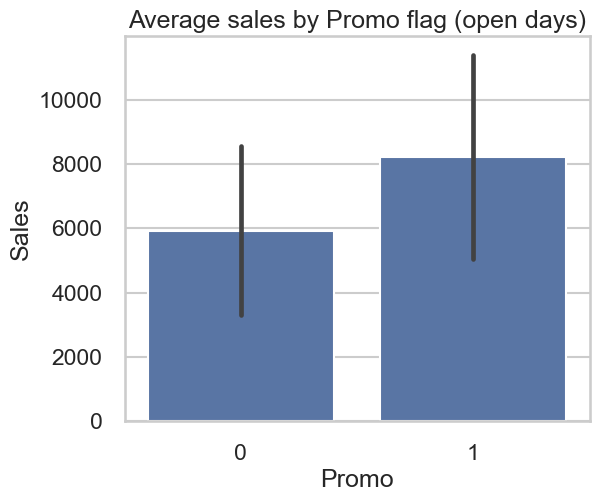

In [51]:
# Promo effect on Sales (open days only)
open_days = train_full[train_full["Open"] == 1]
promo_summary = (open_days
                 .groupby("Promo")["Sales"]
                 .agg(["mean", "median", "count"])
                 .rename_axis("Promo"))
print("Promo impact summary:")
display(promo_summary)
plt.figure(figsize=(6, 5))
sns.barplot(data=open_days, x="Promo", y="Sales", estimator=np.mean, errorbar="sd")
plt.title("Average sales by Promo flag (open days)")
plt.show()

[11:51:49] INFO     Using categorical units to plot a list of   category.py:224
                    strings that are all parsable as floats or                 
                    dates. If these strings should be plotted                  
                    as numbers, cast to the appropriate data                   
                    type before plotting.                                      
[11:51:50] INFO     Using categorical units to plot a list of   category.py:224
                    strings that are all parsable as floats or                 
                    dates. If these strings should be plotted                  
                    as numbers, cast to the appropriate data                   
                    type before plotting.                                      
[11:51:50] INFO     Using categorical units to plot a list of   category.py:224
                    strings that are all parsable as floats or                 
                    dates. If these stri

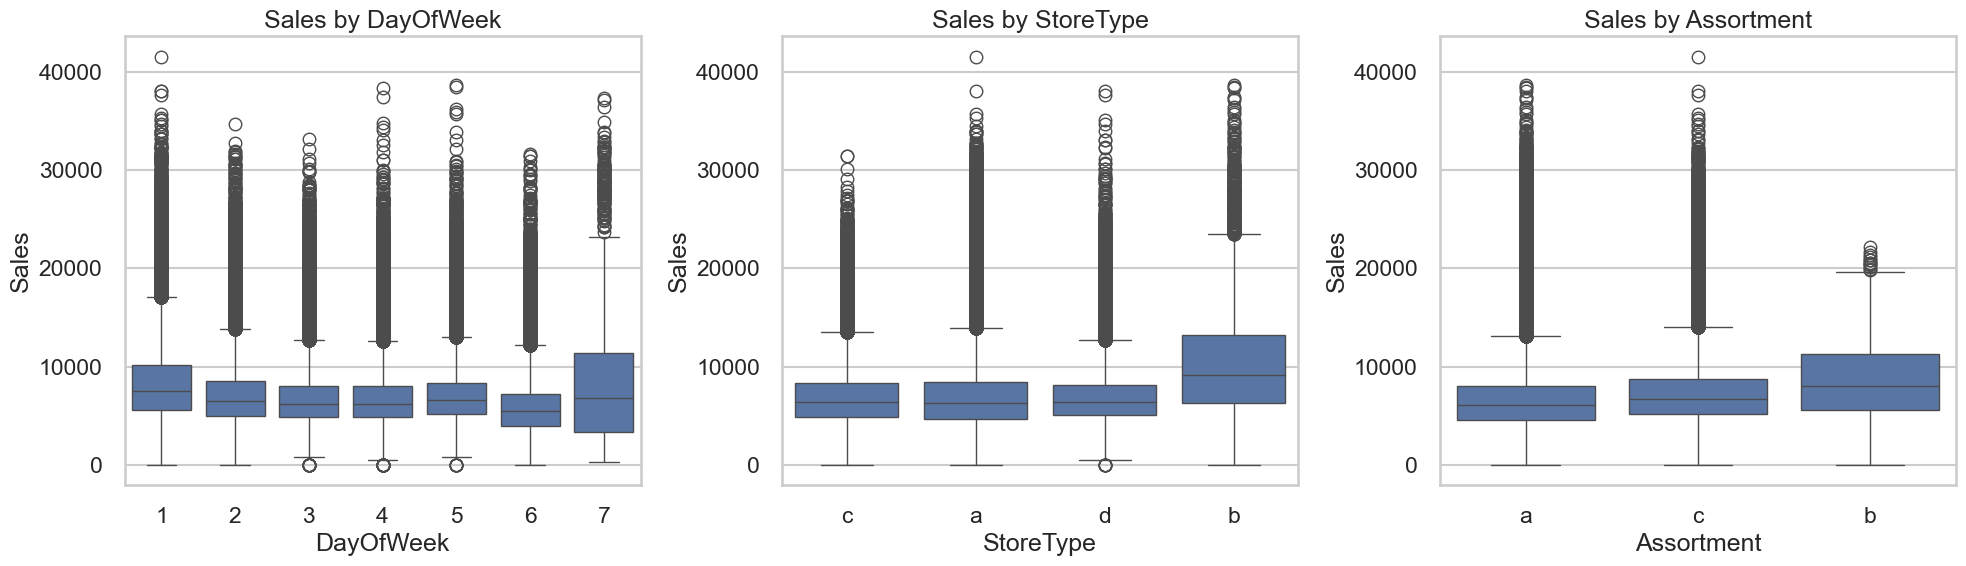

In [52]:
# Boxplots by categorical drivers
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
sns.boxplot(data=open_days, x="DayOfWeek", y="Sales", ax=axes[0])
axes[0].set_title("Sales by DayOfWeek")
sns.boxplot(data=open_days, x="StoreType", y="Sales", ax=axes[1])
axes[1].set_title("Sales by StoreType")
sns.boxplot(data=open_days, x="Assortment", y="Sales", ax=axes[2])
axes[2].set_title("Sales by Assortment")
plt.tight_layout()
plt.show()

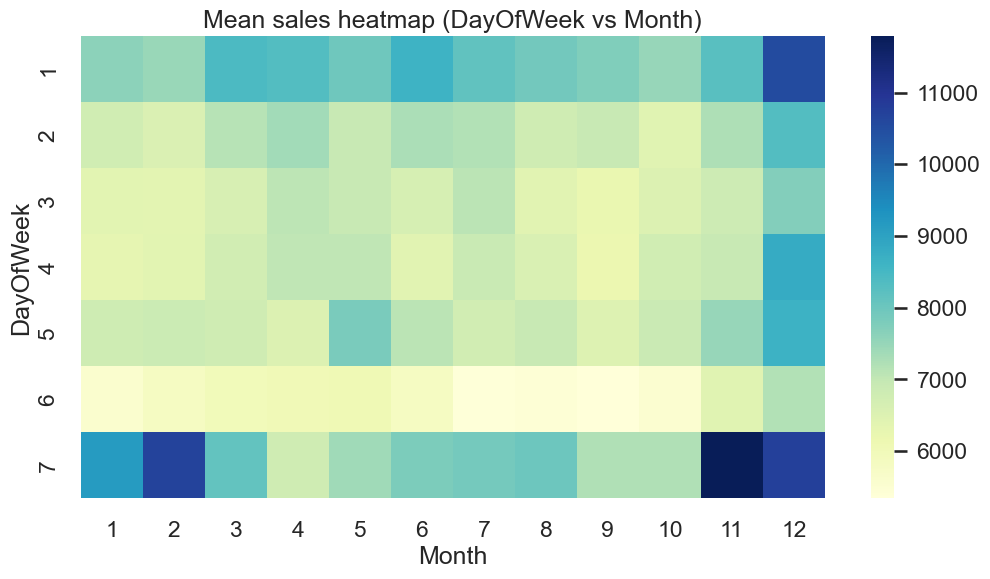

In [53]:
# Heatmap of mean sales by DayOfWeek x Month
heat_df = (open_days
           .assign(Month=open_days["Date"].dt.month)
           .groupby(["DayOfWeek", "Month"])["Sales"].mean()
           .unstack("Month"))
plt.figure(figsize=(12, 6))
sns.heatmap(heat_df, cmap="YlGnBu")
plt.title("Mean sales heatmap (DayOfWeek vs Month)")
plt.ylabel("DayOfWeek")
plt.show()

## Giai đoạn 4: Feature Engineering (Chuẩn Kaggle)

Xây dựng bộ đặc trưng không rò rỉ: đặc trưng thời gian, lag/rolling theo Store, và đặc trưng cạnh tranh/promo dựa trên thông tin thời điểm kích hoạt.

In [54]:
# Feature engineering helpers (no leakage)
def add_date_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Day"] = df["Date"].dt.day
    df["DayOfWeek"] = df["Date"].dt.dayofweek + 1  # align with Rossmann convention
    df["WeekOfYear"] = df["Date"].dt.isocalendar().week.astype(int)
    df["IsWeekend"] = df["DayOfWeek"].isin([6, 7]).astype(int)
    df["IsMonthStart"] = df["Date"].dt.is_month_start.astype(int)
    df["IsMonthEnd"] = df["Date"].dt.is_month_end.astype(int)
    return df

def add_competition_promo_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    comp_open = pd.to_datetime({
        "year": df["CompetitionOpenSinceYear"],
        "month": df["CompetitionOpenSinceMonth"],
        "day": 1
    }, errors="coerce")
    df["CompetitionMonthsActive"] = ((df["Date"] - comp_open).dt.days / 30).clip(lower=0)

    def promo2_start(row):
        if pd.isna(row["Promo2SinceYear"]) or pd.isna(row["Promo2SinceWeek"]):
            return pd.NaT
        year = int(row["Promo2SinceYear"])
        week = int(row["Promo2SinceWeek"])
        return pd.to_datetime(f"{year}-{week}-1", format="%Y-%W-%w", errors="coerce")

    promo_start = df.apply(promo2_start, axis=1)
    df["Promo2WeeksActive"] = ((df["Date"] - promo_start).dt.days / 7).clip(lower=0)
    df["PromoIntervalActive"] = df.apply(
        lambda row: int(row["Date"].strftime("%b") in row["PromoInterval"].split(","))
        if isinstance(row["PromoInterval"], str) and row["PromoInterval"] != "None" else 0,
        axis=1
    )
    return df

def add_lag_rolling_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.sort_values(["Store", "Date"]).copy()
    for lag in [1, 7]:
        df[f"Lag_{lag}"] = df.groupby("Store")["Sales"].shift(lag)
    lagged_sales = df.groupby("Store")["Sales"].shift(1)
    df["Rolling_Mean_7"] = (lagged_sales.groupby(df["Store"])
                             .rolling(window=7)
                             .mean()
                             .reset_index(level=0, drop=True))
    df["Rolling_Std_7"] = (lagged_sales.groupby(df["Store"])
                            .rolling(window=7)
                            .std()
                            .reset_index(level=0, drop=True))
    return df

In [55]:
# Apply feature engineering to train/test consistently
train_aug = train_full.copy()
test_aug = test_full.copy()
train_aug["dataset"] = "train"
test_aug["dataset"] = "test"
combined = pd.concat([train_aug, test_aug], ignore_index=True, sort=False)
combined = add_date_features(combined)
combined = add_competition_promo_features(combined)
combined = add_lag_rolling_features(combined)

train_fe = combined[combined["dataset"] == "train"].drop(columns=["dataset"]).copy()
test_fe = combined[combined["dataset"] == "test"].drop(columns=["dataset", "Sales", "Customers"], errors="ignore").copy()

feature_cols = [
    "Year", "Month", "WeekOfYear", "IsWeekend", "Lag_1", "Lag_7",
    "Rolling_Mean_7", "Rolling_Std_7", "CompetitionMonthsActive", "Promo2WeeksActive",
    "PromoIntervalActive"
]
print("Feature snapshot (train):")
display(train_fe[feature_cols].head())

Feature snapshot (train):


,Year,Month,WeekOfYear,IsWeekend,Lag_1,Lag_7,Rolling_Mean_7,Rolling_Std_7,CompetitionMonthsActive,Promo2WeeksActive,PromoIntervalActive
1000485,2013,1,1,0,NaN,NaN,NaN,NaN,52.77,NaN,0
999370,2013,1,1,0,0.00,NaN,NaN,NaN,52.80,NaN,0
998255,2013,1,1,0,5530.00,NaN,NaN,NaN,52.83,NaN,0
997140,2013,1,1,0,4327.00,NaN,NaN,NaN,52.87,NaN,0
996025,2013,1,1,1,4486.00,NaN,NaN,NaN,52.90,NaN,0


## Giai đoạn 5: Chiến lược validation & baseline

Không dùng random split vì dữ liệu chuỗi thời gian phụ thuộc thứ tự. Ta cắt 6 tuần cuối làm validation để mô phỏng thử thách Kaggle (train trên phần đầu, dự báo đoạn cuối). Baseline đơn giản: dự báo bằng Lag_1 theo Store (giống phương pháp Naïve khoá học) để nhanh chóng đo lường MAE và xác định mức cải thiện cần đạt.

In [56]:
# Time-based holdout (last 6 weeks) + naïve baseline using Lag_1
train_fe_sorted = train_fe.sort_values(["Store", "Date"])
validation_horizon = pd.Timedelta(weeks=6)
split_date = train_fe_sorted["Date"].max() - validation_horizon
train_split = train_fe_sorted[train_fe_sorted["Date"] < split_date]
val_split = train_fe_sorted[train_fe_sorted["Date"] >= split_date]

baseline_pred = val_split["Lag_1"].fillna(train_split["Sales"].median())
val_mae = (val_split["Sales"] - baseline_pred).abs().mean()

print(f"Split date: {split_date.date()}")
print(f"Train span : {train_split['Date'].min().date()} -> {train_split['Date'].max().date()} (rows={len(train_split)})")
print(f"Valid span : {val_split['Date'].min().date()} -> {val_split['Date'].max().date()} (rows={len(val_split)})")
print(f"Naïve Lag_1 MAE: {val_mae:,.2f}")

Split date: 2015-06-05
Train span : 2013-01-01 -> 2015-06-04 (rows=953654)
Valid span : 2015-06-05 -> 2015-07-17 (rows=47945)
Naïve Lag_1 MAE: 2,761.55


In [57]:
train_fe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1001599 entries, 1000485 to 1114
Data columns (total 40 columns):
 #   Column                                Non-Null Count    Dtype         
---  ------                                --------------    -----         
 0   Store                                 1001599 non-null  int64         
 1   DayOfWeek                             1001599 non-null  int32         
 2   Date                                  1001599 non-null  datetime64[ns]
 3   Sales                                 1001599 non-null  float64       
 4   Customers                             1001599 non-null  int64         
 5   Open                                  1001599 non-null  int64         
 6   Promo                                 1001599 non-null  int64         
 7   StateHoliday                          1001599 non-null  object        
 8   SchoolHoliday                         1001599 non-null  int64         
 9   Id                                    1001599 no

In [58]:
train_fe.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Id,...,IsWeekend,IsMonthStart,IsMonthEnd,CompetitionMonthsActive,Promo2WeeksActive,PromoIntervalActive,Lag_1,Lag_7,Rolling_Mean_7,Rolling_Std_7
1000485,1,2,2013-01-01,0.00,0,0,0,a,1,690197,...,0,1,0,52.77,NaN,0,NaN,NaN,NaN,NaN
999370,1,3,2013-01-02,5530.00,668,1,0,0,1,988300,...,0,0,0,52.80,NaN,0,0.00,NaN,NaN,NaN
998255,1,4,2013-01-03,4327.00,578,1,0,0,1,919910,...,0,0,0,52.83,NaN,0,5530.00,NaN,NaN,NaN
997140,1,5,2013-01-04,4486.00,619,1,0,0,1,662609,...,0,0,0,52.87,NaN,0,4327.00,NaN,NaN,NaN
996025,1,6,2013-01-05,4997.00,635,1,0,0,1,1008092,...,1,0,0,52.90,NaN,0,4486.00,NaN,NaN,NaN


In [59]:
def drop_columns(df, columns):
    df = df.copy()
    return df.drop(columns=columns, errors="ignore")

columns = ["Id", "Date", "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear",
           "Promo2SinceWeek", "Promo2SinceYear","PromoInterval","CompetitionOpenSinceMonthMissingFlag",
           "CompetitionOpenSinceYearMissingFlag","Promo2SinceWeekMissingFlag","Promo2SinceYearMissingFlag",
           "PromoIntervalMissingFlag"]

train_fe = drop_columns(train_fe, columns)
test_fe =drop_columns(test_fe, columns)

In [60]:
# Lọc những ngày bán hàng Open = 1
train_fe = train_fe[train_fe["Open"] == 1].copy()
test_fe = test_fe[test_fe["Open"] == 1].copy()

In [62]:
train_fe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 830972 entries, 999370 to 1114
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Store                    830972 non-null  int64  
 1   DayOfWeek                830972 non-null  int32  
 2   Sales                    830972 non-null  float64
 3   Customers                830972 non-null  int64  
 4   Open                     830972 non-null  int64  
 5   Promo                    830972 non-null  int64  
 6   StateHoliday             830972 non-null  object 
 7   SchoolHoliday            830972 non-null  int64  
 8   StoreType                830972 non-null  object 
 9   Assortment               830972 non-null  object 
 10  CompetitionDistance      830972 non-null  float64
 11  Promo2                   830972 non-null  int64  
 12  CompetitionMissingFlag   830972 non-null  int64  
 13  LogSales                 830972 non-null  float64
 14  Year  

In [63]:
# Lưu các file đã chỉnh sửa gần đây
train_fe.to_parquet(DATA_DIR / "train_fe.parquet", index=False)
test_fe.to_parquet(DATA_DIR / "test_fe.parquet", index=False)

### Next steps
- Chuẩn hoá thêm các holiday/marketing calendar bên ngoài nếu có.
- Huấn luyện các mô hình baseline (XGBoost, LightGBM, SARIMAX) sử dụng bộ đặc trưng đã tạo.
- Thử nghiệm nhiều chiến lược validation dạng rolling window để bám sát public leaderboard.